In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from hmmlearn.hmm import GaussianHMM
from pykalman import KalmanFilter

from backtesting import Backtest, Strategy
from backtesting.lib import crossover
from backtesting.test import SMA
from backtesting.lib import plot_heatmaps

import matplotlib.dates as mdates

import warnings
warnings.filterwarnings('ignore')

c:\Users\Benjamin_Chan\Documents\Python\Finance\quant-finance-seminar\venv\Lib\site-packages\backtesting\_plotting.py:55: UserWarning: Jupyter Notebook detected. Setting Bokeh output to notebook. This may not work in Jupyter clients without JavaScript support, such as old IDEs. Reset with `backtesting.set_bokeh_output(notebook=False)`.
  warnings.warn('Jupyter Notebook detected. '


Loading BokehJS ...

Load SPY data

In [2]:
spy = pd.read_csv('data/spy.csv')

In [3]:
spy.head(), spy.tail()

(         Date      Close       High        Low       Open     Volume
 0  2010-01-04  85.768448  85.813854  84.391067  85.041918  118944600
 1  2010-01-05  85.995476  86.033318  85.405171  85.715463  111579900
 2  2010-01-06  86.056015  86.267919  85.844111  85.912221  116074400
 3  2010-01-07  86.419304  86.525256  85.654932  85.897108  131091100
 4  2010-01-08  86.706863  86.744706  86.018176  86.192237  126402800,
             Date       Close        High         Low        Open    Volume
 3768  2024-12-23  592.906433  593.514589  585.897488  589.117842  57635800
 3769  2024-12-24  599.496582  599.536501  593.684050  594.272307  33160100
 3770  2024-12-26  599.536499  600.673034  596.286267  597.701991  41219100
 3771  2024-12-27  593.225464  595.987176  588.988210  595.747844  64969300
 3772  2024-12-30  586.455811  589.965273  582.657240  586.126844  56578800)

Split data into train set (2010 to 2020) and test set (2021 to 2024)

In [7]:
data_train = spy[spy.Date < "2020-12-31"]
data_test = spy[spy.Date > "2020-12-31"]

data_train["Returns"] = np.log(data_train['Close']).diff().dropna()
data_test["Returns"] = np.log(data_test['Close']).diff().dropna()

data_train = data_train.dropna()
data_test = data_test.dropna()

data_train['Date'] = pd.to_datetime(data_train['Date'])  # Ensure proper datetime format
data_train.set_index('Date', inplace=True)
data_test['Date'] = pd.to_datetime(data_test['Date'])  # Ensure proper datetime format
data_test.set_index('Date', inplace=True)

Prepare return data for HMM training

In [8]:
# Prepare training data(log return) for HMM
X_train = np.array(data_train["Returns"]).reshape(-1,1)
X_train

array([[ 0.00264349],
       [ 0.00070373],
       [ 0.00421265],
       ...,
       [ 0.00855428],
       [-0.00190958],
       [ 0.00142553]], shape=(2767, 1))

Train 2 state HMM model and print the model parameters (initial states proabitility, Transition matrix and Emmsion Probabilities)

In [9]:
# Train HMM Model
hmm_model = GaussianHMM(n_components=2, n_iter=100, random_state=42).fit(X_train)
print("Model Score:", hmm_model.score(X_train))

Model is not converging.  Current: 9208.559304714225 is not greater than 9208.585917866636. Delta is -0.02661315241130069


Model Score: 9208.461525352739


In [10]:
# Model parameters
print(f"means : \n {hmm_model.means_}")
print("-----")
print(f"covariance matrix : \n {hmm_model.covars_}")
print("-----")
print(f"transition matrix : \n {hmm_model.transmat_}")

means : 
 [[ 0.00102401]
 [-0.00150983]]
-----
covariance matrix : 
 [[[4.7395647e-05]]

 [[4.2980242e-04]]]
-----
transition matrix : 
 [[0.98630756 0.01369244]
 [0.05357379 0.94642621]]


In [11]:
# Expected time to stay in the regimes
T_bull = 1 / (1 - hmm_model.transmat_[0][0])
T_bear = 1 / (1 - hmm_model.transmat_[1][1])
print(f"Expected Duration of Bull Regime : {T_bull} trading days")
print(f"Expected Duration of Bear Regime : {T_bear} trading days")
# Observation is difference from the expectation

Expected Duration of Bull Regime : 73.03300347160005 trading days
Expected Duration of Bear Regime : 18.665842995858288 trading days


In [12]:
# Check results
hidden_states = hmm_model.predict(X_train)
# Note that the predict mehod find the most likely sequence by forward-backwards algorithm.
# Should use the forward algorithm to estimate the posterior probability of a state
hidden_states[:5]

array([0, 0, 0, 0, 0])

In [13]:
# Use the forward algorithm to estimate the posterior probability of a state
#X= np.array(data_train["Returns"]).reshape(-1,1)
hidden_states_proba = hmm_model.predict_proba(X_train)

In [19]:
hidden_states_proba.T[0]

array([1.        , 0.99917998, 0.99762698, ..., 0.99795932, 0.99671194,
       0.99265818], shape=(2767,))

In [20]:
data_train["state 0 probability"] = hidden_states_proba.T[0]
data_train.head()

,Close,High,Low,Open,Volume,Returns,state 0 probability
Date,,,,,,,
2010-01-05,85.995476,86.033318,85.405171,85.715463,111579900,0.002643,1.000000
2010-01-06,86.056015,86.267919,85.844111,85.912221,116074400,0.000704,0.999180
2010-01-07,86.419304,86.525256,85.654932,85.897108,131091100,0.004213,0.997627
2010-01-08,86.706863,86.744706,86.018176,86.192237,126402800,0.003322,0.993481
2010-01-11,86.827972,87.130689,86.457135,87.092852,106375700,0.001396,0.980897


Visulize Close Price and Probability of Bull Market

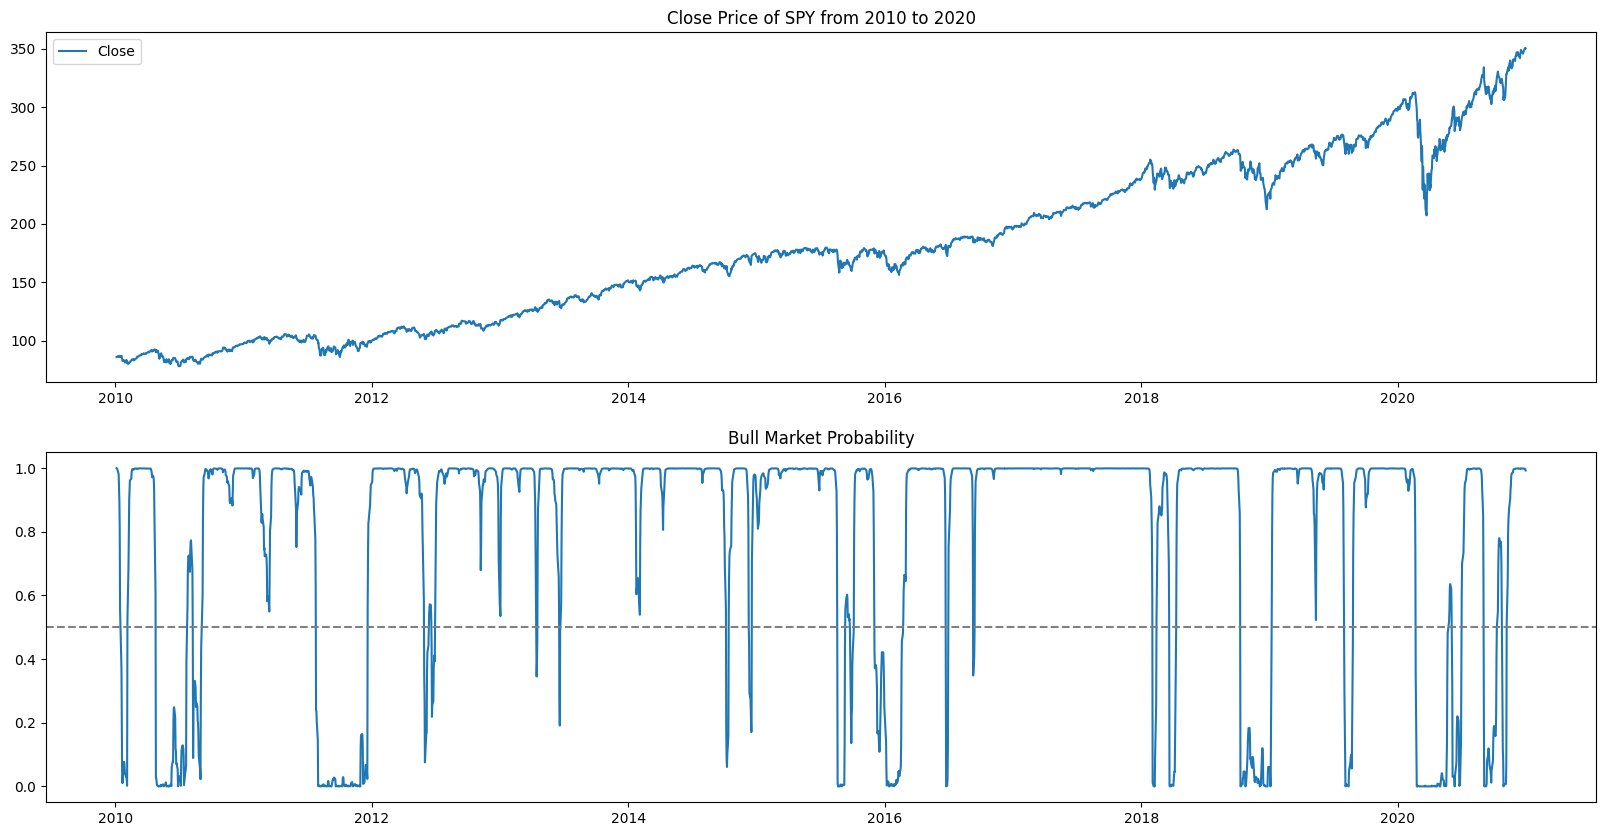

In [60]:
# Create a figure and subplots
plt.figure(figsize=(20, 10))

# Subplot 1: Close 
plt.subplot(2, 1, 1)
plt.plot(data_train.index, data_train.Close, label="Close")
prices = data_train["Close"].values.astype(float)
plt.legend()
plt.title('Close Price of SPY from 2010 to 2020')

# Subplot 2: State 0
plt.subplot(2, 1, 2)
plt.plot(data_train.index, data_train["state 0 probability"], label="Probability")
plt.axhline(0.5, color='gray', linestyle='--')
plt.title('Bull Market Probability')

plt.show()

Trading Strategy: Hold in Bull Market and Close position in Bear Market

Backtesting with train data

In [ ]:
# 1. Helper to extract data columns
def Extract(data, column):
    return data[column]


class RegimeHoldStrategy(Strategy):
    # Define defaults as class attributes
    enter_threshold = 0.5
    exit_threshold = 0.6

    def init(self):
        self.proba = self.I(Extract, self.data, 'state 0 probability')
        self.in_regime = False

    def next(self):
        proba_now = self.proba[-1]
        proba_prev = self.proba[-2] if len(self.proba) > 1 else self.proba[-1]

        if not self.position:
            if proba_prev < self.enter_threshold and proba_now >= self.enter_threshold:
                self.buy()
                self.in_regime = True

        elif self.position:
            if proba_prev > self.exit_threshold and proba_now <= self.exit_threshold:
                self.position.close()
                self.in_regime = False

In [42]:
from backtesting import Backtest

bt = Backtest(
    data_train,                   # your historical data
    RegimeHoldStrategy,           # the strategy you pasted
    cash=10_000,
    commission=0.001,             # optional commission
    exclusive_orders=True,         # prevents overlapping trades
    trade_on_close=True
)

# Run the backtest
stats = bt.run()

# Plot and show results
bt.plot()
print(stats)

Start                     2010-01-05 00:00:00
End                       2020-12-30 00:00:00
Duration                   4012 days 00:00:00
Exposure Time [%]                    65.30538
Equity Final [$]                   59560.4994
Equity Peak [$]                   59589.32905
Commissions [$]                    1133.90382
Return [%]                          495.60499
Buy & Hold Return [%]               307.30963
Return (Ann.) [%]                    17.64624
Volatility (Ann.) [%]                10.07831
CAGR [%]                             11.86039
Sharpe Ratio                          1.75091
Sortino Ratio                         3.24217
Calmar Ratio                          2.07445
Alpha [%]                           419.89901
Beta                                  0.24635
Max. Drawdown [%]                    -8.50648
Avg. Drawdown [%]                    -0.96343
Max. Drawdown Duration      326 days 00:00:00
Avg. Drawdown Duration       17 days 00:00:00
# Trades                          

In [ ]:
bt = Backtest(
    data_train,
    RegimeHoldStrategy,    # your updated version
    cash=10_000,
    commission=0.001,
    exclusive_orders=True,
    trade_on_close=True
)
# Optimize enter and exit threshold
stats, heatmap = bt.optimize(
    enter_threshold=(0.4, 0.6, 0.02),   # Correct tuple format
    exit_threshold=(0.6, 0.8, 0.02),    # Correct tuple format
    constraint=lambda p: p.enter_threshold < p.exit_threshold,
    maximize='Sharpe Ratio',
    return_heatmap=True
)

In [48]:
stats

Start                     2010-01-05 00:00:00
End                       2020-12-30 00:00:00
Duration                   4012 days 00:00:00
Exposure Time [%]                    75.93061
Equity Final [$]                  77987.97708
Equity Peak [$]                   78025.62522
Commissions [$]                     1231.2431
Return [%]                          679.87977
Buy & Hold Return [%]               307.30963
Return (Ann.) [%]                    20.57019
Volatility (Ann.) [%]                11.41293
CAGR [%]                              13.7705
Sharpe Ratio                          1.80236
Sortino Ratio                         3.32382
Calmar Ratio                          2.41226
Alpha [%]                           587.38974
Beta                                  0.30097
Max. Drawdown [%]                    -8.52736
Avg. Drawdown [%]                    -1.02316
Max. Drawdown Duration      264 days 00:00:00
Avg. Drawdown Duration       15 days 00:00:00
# Trades                          

In [51]:
heatmap

enter_threshold  exit_threshold
0.40             0.6               1.584679
                 0.8               1.598691
0.60             0.8               1.802360
0.02             0.6               0.988481
                 0.8               1.151884
Name: Sharpe Ratio, dtype: float64

In [53]:
heatmap.sort_values(ascending=False)

enter_threshold  exit_threshold
0.60             0.8               1.802360
0.40             0.8               1.598691
                 0.6               1.584679
0.02             0.8               1.151884
                 0.6               0.988481
Name: Sharpe Ratio, dtype: float64

Backtesting with test data 

In [32]:
X_test = np.array(data_test["Returns"]).reshape(-1,1)
hidden_states_proba = hmm_model.predict_proba(X_test)
data_test["state 0 probability"] = hidden_states_proba.T[0]
data_test.dropna(inplace = True)

In [54]:
class RegimeHoldStrategy(Strategy):
    # Define defaults as class attributes
    enter_threshold = 0.6
    exit_threshold = 0.8

    def init(self):
        self.proba = self.I(Extract, self.data, 'state 0 probability')
        self.in_regime = False

    def next(self):
        proba_now = self.proba[-1]
        proba_prev = self.proba[-2] if len(self.proba) > 1 else self.proba[-1]

        if not self.position:
            if proba_prev < self.enter_threshold and proba_now >= self.enter_threshold:
                self.buy()
                self.in_regime = True

        elif self.position:
            if proba_prev > self.exit_threshold and proba_now <= self.exit_threshold:
                self.position.close()
                self.in_regime = False



bt = Backtest(
    data_test,                   # your historical data
    RegimeHoldStrategy,           # the strategy you pasted
    cash=10_000,
    commission=0.001,             # optional commission
    exclusive_orders=True,         # prevents overlapping trades
    trade_on_close=True
)

# Run the backtest
stats = bt.run()

# Plot and show results
bt.plot()
print(stats)

Start                     2021-01-05 00:00:00
End                       2024-12-30 00:00:00
Duration                   1455 days 00:00:00
Exposure Time [%]                    63.60917
Equity Final [$]                  18001.20424
Equity Peak [$]                   18473.31145
Commissions [$]                     146.80816
Return [%]                           80.01204
Buy & Hold Return [%]                67.72823
Return (Ann.) [%]                    15.91605
Volatility (Ann.) [%]                13.59199
CAGR [%]                             10.71773
Sharpe Ratio                          1.17099
Sortino Ratio                         2.11887
Calmar Ratio                          0.96541
Alpha [%]                            45.67164
Beta                                  0.50703
Max. Drawdown [%]                   -16.48624
Avg. Drawdown [%]                    -1.45814
Max. Drawdown Duration      255 days 00:00:00
Avg. Drawdown Duration       22 days 00:00:00
# Trades                          

In [55]:
# Calculate Sharpe Ratio of SPY from 2018 on
spy_prices = data_test.copy()

# Calculate daily log returns
spy_prices['return'] = spy_prices['Close'] / spy_prices['Close'].shift(1) -1

# Annualize the average log return
mean_return_daily = spy_prices['return'].mean()
mean_return_annualized = mean_return_daily * 252  # Assuming 252 trading days in a year

# Risk-free rate
risk_free_rate = 0  # Take risk free rate as 0

# Calculate the standard deviation of the daily returns
std_deviation_daily = spy_prices['return'].std()
std_deviation_annualized = std_deviation_daily * np.sqrt(252)

# Calculate the Sharpe Ratio
sharpe_ratio = (mean_return_annualized - risk_free_rate) / std_deviation_annualized

print("Sharpe Ratio of Benchmark (SPY):", sharpe_ratio)

Sharpe Ratio of Benchmark (SPY): 0.8714823734246389


In [56]:
# Calculate MDD of SPY from 2018 on
close_price = spy_prices.Close

def calculate_mdd(prices):
    max_drawdown = 0
    peak = prices.iloc[0]

    for price in prices:
        if price > peak:
            peak = price
        drawdown = (peak - price) / peak
        max_drawdown = max(max_drawdown, drawdown)

    return max_drawdown
mdd = calculate_mdd(close_price)
print(f"Maximum Drawdown of Benchmark (SPY): {mdd * 100:.2f}%")

Maximum Drawdown of Benchmark (SPY): 24.50%


In [57]:
sharpe_strategy_1 = stats["Sharpe Ratio"]
print(f"Sharpe Ratio of Benchmark(SPY) : {sharpe_ratio}")
print(f"Sharpe Ratio of Strategy: {sharpe_strategy_1}")

MDD_strategy_1 = stats["Max. Drawdown [%]"] / -100
print(f"MDD of Benchmark(SPY) : {mdd}")
print(f"MDD of Strategy: {MDD_strategy_1}")

Sharpe Ratio of Benchmark(SPY) : 0.8714823734246389
Sharpe Ratio of Strategy: 1.1709868238028587
MDD of Benchmark(SPY) : 0.24496379384165567
MDD of Strategy: 0.1648623782220513


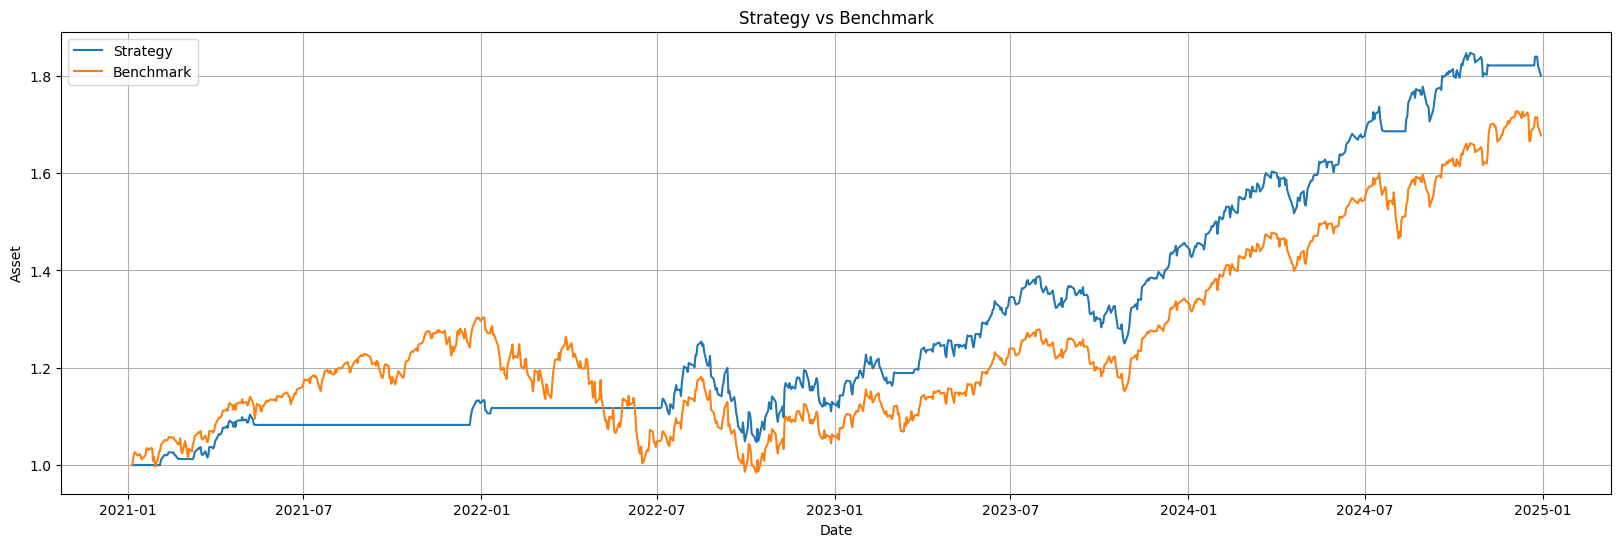

In [58]:
plt.figure(figsize = (20,6))
plt.plot(stats._equity_curve.index, stats._equity_curve.Equity / 10000, label = "Strategy")
plt.plot(data_test.index, data_test.Close / data_test.Close.iloc[0] , label = "Benchmark")
plt.title("Strategy vs Benchmark")
plt.xlabel("Date")
plt.ylabel("Asset")
plt.legend()
plt.grid()
plt.show()